In [ ]:
"""
Copyright (c) 2025, Majed Kikhia
All rights reserved.

This source code is licensed under the BSD-style license found in the
LICENSE file in the root directory of this source tree. 

Author: Majed Kikhia
December 2025

#####################################################################################################
This code contains elements adapted from the following GitHub repository published under MIT license: 

Bhattiprolu, S. (2023). python_for_microscopists. GitHub.
https://github.com/bnsreenu/python_for_microscopists

MIT License

Copyright (c) 2023 Dr. Sreenivas Bhattiprolu

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
#####################################################################################################

Input: raw czi files for microscopy images of microglia and their corresponding binary masks for training

What does this code do? 
The code split the raw images and the binary masks into 256x256 patches, build a U-Net model, train the model,
and save the trained model. 

Output: the U-Net model saved as h5 file. 
"""


import tensorflow as tf
from keras.utils import normalize
from keras import backend as K

import glob, os
import random
import numpy as np
from patchify import patchify, unpatchify
import czifile
import tifffile
 
import matplotlib.pyplot as plt

2023-11-28 23:32:10.790127: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Create the parameters needed for reading the z-stacks and spliting them into patches of 256x256. 

seed = 42
np.random.seed = seed

patch_size=256
IMG_WIDTH = patch_size
IMG_HEIGHT = patch_size
IMG_CHANNELS = 1

IMG_PATH = "Train/"
MASK_PATH = "Masks/"

image_dataset = []
mask_dataset = []

shapes = []

In [5]:
# For training on czi raw files directly
# Reading the raw z-stacks and spliting them into patches of 256x256 and save the patches into one dataset

os.chdir(IMG_PATH)

print("Here are the analyzed images sorted in this order:")

for file in sorted(glob.glob("*.czi")):
    print(file)
    img = czifile.imread(file)
    
    # Extracting the RFP channel (first channel)
    img = img[0, 0, 0, 0, :, :, :, :]
    
    # Splitting the image into smaller patches
    patches = patchify(img, (img.shape[0], patch_size, patch_size, 1), step=patch_size) 
    patches = patches[0, :, :, 0, :, :, :]
    
    patches_shape = patches.shape 
    
    # Reshaping patches in apporperiate shape for training
    patches = np.reshape(patches, (patches_shape[0]*patches_shape[1]*patches_shape[2], patch_size, patch_size, 1))
        
    # Appending all patches in one array
    shapes.append(patches_shape)
    image_dataset.append(patches)
    
image_dataset = np.concatenate(image_dataset[:], axis=0)
image_dataset = np.array(image_dataset / 65535, dtype=np.float64) # Normalize data from 16-bit to 0 to 1 float64 

Here are the analyzed images sorted in this order:
20220906_L6_KGE-4590_2d_contra_2.czi
20220908_L6_KGE-4460_2d_ipsi_3.czi
20220909_L6_KGE-4607_2d_ipsi_5.czi
20220911_L8_KGE-5193_2d_contra_3.czi
20220912_L6_KGE-4608_8w_ipsi_4.czi
20220914_L9_KGE-5314_8w_ipsi_2.czi
20220916_L7_KGE-4774_1w_ipsi_3.czi
20220919_L9_KGE-5312_1w_ipsi_2.czi
20220919_L9_KGE-5313_1w_contra_4.czi


In [6]:
# Reading the ground truth masks (z-stacks) and spliting them into patches of 256x256 and save the patches into one dataset

os.chdir(os.pardir)
os.chdir(MASK_PATH)

print("Here are the matching masks sorted in this order:")

for file in sorted(glob.glob("*.tif")):
    print(file)
    img = tifffile.imread(file)
    img = np.expand_dims(img, axis=-1)
    patches = patchify(img, (img.shape[0], patch_size, patch_size, 1), step=patch_size)
    patches = patches[0, :, :, 0, :, :, :]
    
    patches_shape = patches.shape 
    patches = np.reshape(patches, (patches_shape[0]*patches_shape[1]*patches_shape[2], patch_size, patch_size, 1))
    mask_dataset.append(patches)

mask_dataset = np.concatenate(mask_dataset[:], axis=0)
mask_dataset = np.array(mask_dataset / 255, dtype=np.float64) # Normalize masks from 8-bit to 0 to 1 float64 
os.chdir(os.pardir)

Here are the matching masks sorted in this order:
MASK_20220906_L6_KGE-4590_2d_contra_2.tif
MASK_20220908_L6_KGE-4460_2d_ipsi_3.tif
MASK_20220909_L6_KGE-4607_2d_ipsi_5.tif
MASK_20220911_L8_KGE-5193_2d_contra_3.tif
MASK_20220912_L6_KGE-4608_8w_ipsi_4.tif
MASK_20220914_L9_KGE-5314_8w_ipsi_2.tif
MASK_20220916_L7_KGE-4774_1w_ipsi_3.tif
MASK_20220919_L9_KGE-5312_1w_ipsi_2.tif
MASK_20220919_L9_KGE-5313_1w_contra_4.tif


(-0.5, 255.5, 255.5, -0.5)

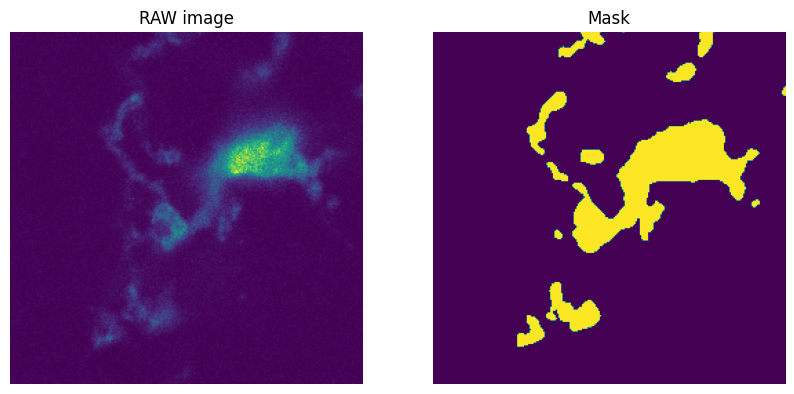

In [12]:
# Plotting a random patch with its mask 

rand_prev = random.randint(0, image_dataset.shape[0])

# checking if the images and mask datasets matches each other 
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(image_dataset[rand_prev, : ,:, 0]*65535)
plt.title("RAW image")
plt.axis("off")

fig.add_subplot(1, 2, 2)
ax2 = plt.imshow(mask_dataset[rand_prev, : ,:, 0])
plt.title("Mask")
plt.axis("off")

In [13]:
# Splitting the data into training and testing datasets with shuffling 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 0, shuffle=True)

print("X_train.shape")
print(X_train.shape)
print("Y_train.shape")
print(Y_train.shape)
print("X_test.shape")
print(X_test.shape)
print("Y_test.shape")
print(Y_test.shape)

X_train.shape
(3758, 256, 256, 1)
Y_train.shape
(3758, 256, 256, 1)
X_test.shape
(418, 256, 256, 1)
Y_test.shape
(418, 256, 256, 1)


(-0.5, 255.5, 255.5, -0.5)

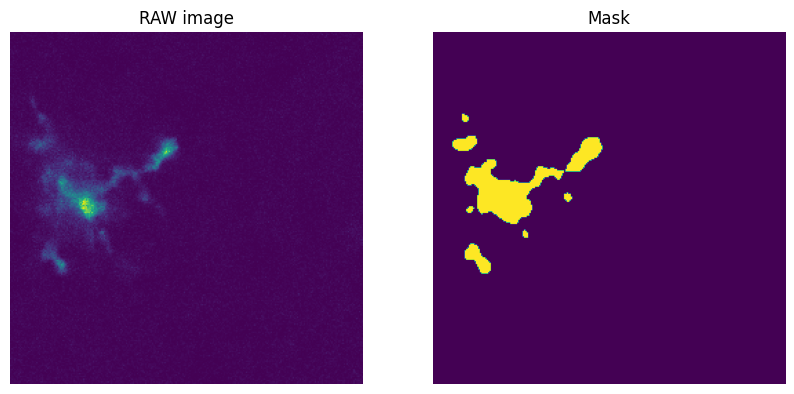

In [55]:
# Checking if the X_train and Y_train still matche each other after data splitting
rand_prev = random.randint(0, X_train.shape[0])

fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(X_train[rand_prev, : ,:, 0]*65535)
plt.title("RAW image")
plt.axis("off")

fig.add_subplot(1, 2, 2)
ax2 = plt.imshow(Y_train[rand_prev, : ,:, 0])
plt.title("Mask")
plt.axis("off")

In [28]:
# Building the model using Keras and Tensorflow 

inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = inputs

# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
     
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
     
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])

model.summary()   

2023-11-28 17:52:03.875184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 17:52:05.857766: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37823 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [29]:
# Training the model

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=25, epochs=100)

Epoch 1/100


2023-11-28 17:52:32.905126: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-28 17:52:36.130071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401
2023-11-28 17:52:38.776712: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-28 17:52:40.272681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-28 17:52:40.321694: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x151fb0e60690 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 17:52:40.321719: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0

136/136 [==============================] - 24s 71ms/step - loss: 0.0701 - mean_io_u: 0.4917 - val_loss: 0.0285 - val_mean_io_u: 0.4902
Epoch 2/100
136/136 [==============================] - 7s 54ms/step - loss: 0.0231 - mean_io_u: 0.4927 - val_loss: 0.0257 - val_mean_io_u: 0.4902
Epoch 3/100
136/136 [==============================] - 7s 53ms/step - loss: 0.0207 - mean_io_u: 0.4929 - val_loss: 0.0232 - val_mean_io_u: 0.4902
Epoch 4/100
136/136 [==============================] - 8s 55ms/step - loss: 0.0194 - mean_io_u: 0.4927 - val_loss: 0.0239 - val_mean_io_u: 0.4903
Epoch 5/100
136/136 [==============================] - 7s 53ms/step - loss: 0.0189 - mean_io_u: 0.4929 - val_loss: 0.0205 - val_mean_io_u: 0.4905
Epoch 6/100
136/136 [==============================] - 7s 53ms/step - loss: 0.0181 - mean_io_u: 0.4929 - val_loss: 0.0236 - val_mean_io_u: 0.4909
Epoch 7/100
136/136 [==============================] - 7s 53ms/step - loss: 0.0177 - mean_io_u: 0.4933 - val_loss: 0.0198 - val_mean_io

Text(0, 0.5, 'Mean_io_u [%]')

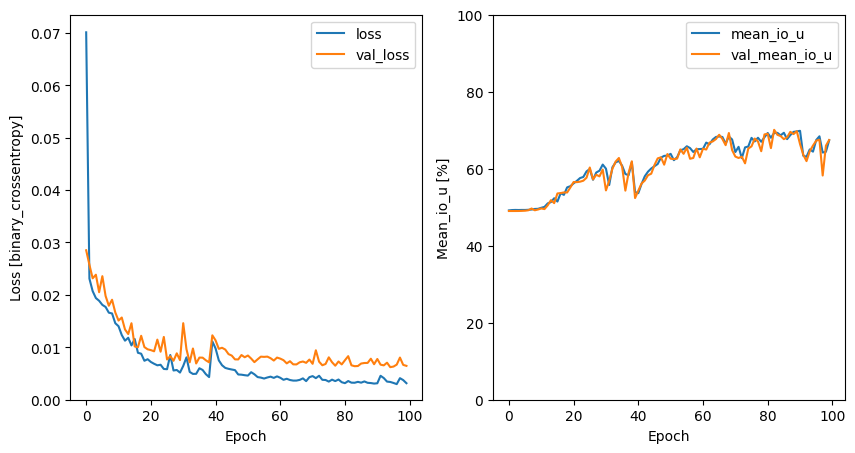

In [30]:
# Plotting performance during training 

metrics_output = results.history

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(results.epoch, metrics_output['loss'], metrics_output['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [binary_crossentropy]')

plt.subplot(1,2,2)
plt.plot(results.epoch, 100*np.array(metrics_output['mean_io_u']), 100*np.array(metrics_output['val_mean_io_u']))
plt.legend(['mean_io_u', 'val_mean_io_u'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Mean_io_u [%]')

In [27]:
# Save the trained model
model.save('microglia_morph_IoU_100ep.h5')

In [17]:
# Loading the model, if starting with pre-trained weights. 
model.load_weights('microglia_morph_IoU_100ep.h5')

In [31]:
# Performing prediction on all three parts of the dataset

preds_train = model.predict(X_train, verbose=1)

preds_test = model.predict(X_test, verbose=1)

# Turning probabilities to binary images 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


14/14 [==============================] - 1s 38ms/step


(-0.5, 255.5, 255.5, -0.5)

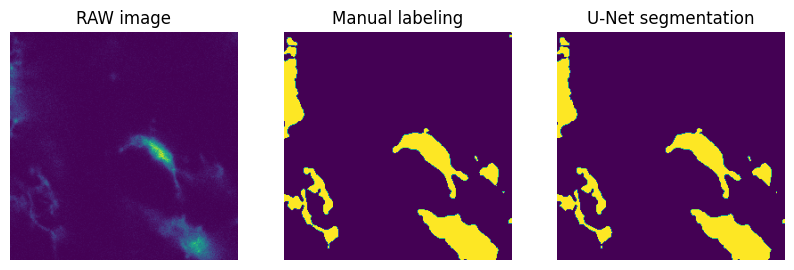

In [36]:
# Compare U-Net segmentation to manual labeling on a random image from the validation dataset 

ix = random.randint(0, len(preds_train_t))

fig = plt.figure(figsize=(10, 7))
# fig.suptitle("Sanity check on some random training samples")

fig.add_subplot(1, 3, 1)
plt.imshow(X_train[ix])
plt.title("RAW image")
plt.axis("off")

fig.add_subplot(1, 3, 2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.title("Manual labeling")
plt.axis("off")

fig.add_subplot(1, 3, 3)
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.title("U-Net segmentation")
plt.axis("off")

(-0.5, 255.5, 255.5, -0.5)

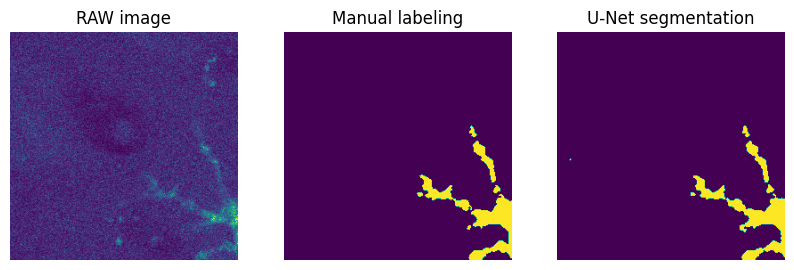

In [42]:
# Compare U-Net segmentation to manual labeling on a random image from the test dataset 

ix = random.randint(0, len(preds_test_t))

fig = plt.figure(figsize=(10, 7))
# fig.suptitle("Sanity check on some random training samples")

fig.add_subplot(1, 3, 1)
plt.imshow(X_test[ix])
plt.title("RAW image")
plt.axis("off")

fig.add_subplot(1, 3, 2)
plt.imshow(np.squeeze(Y_test[ix]))
plt.title("Manual labeling")
plt.axis("off")

fig.add_subplot(1, 3, 3)
plt.imshow(np.squeeze(preds_test_t[ix]))
plt.title("U-Net segmentation")
plt.axis("off")